In [ ]:
!pip install qiskit numpy matplotlib sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


initial theta :  4.315868466677891
[4.31586847]


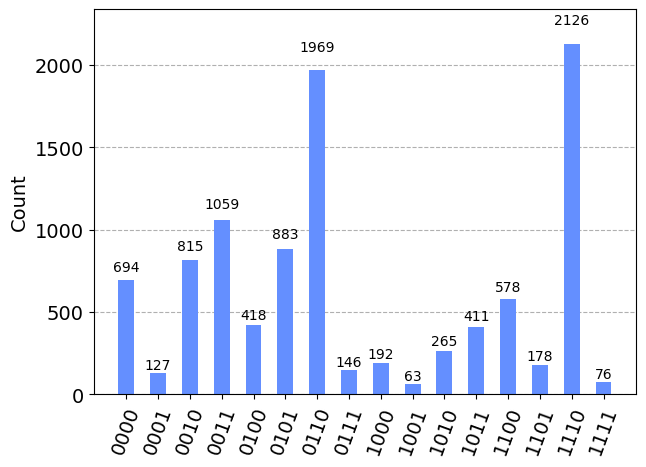

In [ ]:
from qiskit import QuantumCircuit , QuantumRegister, ClassicalRegister, Aer, transpile
from qiskit.circuit import Parameter
from qiskit.providers.aer.noise import NoiseModel
from qiskit.visualization import plot_histogram
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.model_selection import train_test_split
import random
from scipy.optimize import minimize , Bounds 

# Importer le dataset iris
iris = load_iris()

# Normaliser les données
scaler = MinMaxScaler()

X = iris.data
y = iris.target

# Sélection de deux espèces pour la classification binaire
X = scaler.fit_transform(X[np.logical_or(y==0, y==1)])
y = y[np.logical_or(y==0, y==1)]

# Division de l'ensemble de données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


# Encoder les données en utilisant une méthode de codage basée sur des rotations d'angle
nb_qubits = X.shape[1]
qreg = QuantumRegister(nb_qubits, 'q')
creg = ClassicalRegister(nb_qubits, 'c')
circuit = QuantumCircuit(qreg, creg)
for i in range(nb_qubits):
    for j in range(X.shape[0]):
        value = X[j, i]
        circuit.ry(2 * np.pi * value, i)

# Set up the variational circuit
nb_layers = 4
theta = Parameter('theta')
for i in range(nb_qubits):
    circuit.rx(theta, i)
    circuit.barrier()
for layer in range(nb_layers):
    for j in range(nb_qubits):
        circuit.ry(theta, j)
        circuit.barrier()
        for k in range(j+1, nb_qubits):
            circuit.cx(j, k)
            circuit.rz(theta, k)
            circuit.cx(j, k)
            circuit.barrier()

# Add final measurements
for i in range(nb_qubits):
    circuit.measure(i, i)

circuit.draw()

# Define the cost function
backend = Aer.get_backend('qasm_simulator')

counts = Aer.get_backend('qasm_simulator').run(transpile(circuit, backend), shots=1000).result().get_counts()
num_classes = len(set(iris.target))
y = iris.target

def cost(theta):
    exp_vals = np.zeros((num_classes, len(y)))
    for j in range(len(y)):
        for i in range(num_classes):
            for k, v in counts.items():
                if int(k, 2) == i:
                    exp_vals[i][j] = v
            exp_vals[i] = exp_vals[i] / sum(exp_vals[i])
        predicted_class = np.argmax(exp_vals[:,j])
        if predicted_class != y[j]:
            return 1
    return 0

# Run the optimizer
initial_theta = random.uniform(0, 2 * np.pi)
print("initial theta : ", initial_theta)


result = minimize(fun=cost, x0=initial_theta, method='L-BFGS-B', bounds=Bounds(0, 2 * np.pi), tol=0.001, options={'maxiter': 200})

#result = minimize(fun=cost, x0=initial_theta, method='Adagrad', tol=0.001, options={'maxiter': 200})

# Bind the optimized parameter values to the circuit
optimal_theta = result.x
print(optimal_theta)
bound_qc = circuit.bind_parameters({theta: optimal_theta[0]})



# Plot the results
counts = Aer.get_backend('qasm_simulator').run(transpile(bound_qc, backend), shots=10000).result().get_counts()
plot_histogram(counts)

In [ ]:
import numpy as np

# Encode X_test using rotation-based encoding
X_test_encoded = np.zeros((len(X_test), nb_qubits))
for i in range(nb_qubits):
    for j in range(X_test.shape[0]):
        value = X_test[j, i]
        X_test_encoded[j, i] = 2 * np.pi * value

# Make predictions using the bound circuit
y_pred = []
for i in range(len(X_test_encoded)):
    bound_qc = circuit.bind_parameters({theta: optimal_theta[0]})
    for j in range(nb_qubits):
        bound_qc.ry(X_test_encoded[i,j], j)
    counts = Aer.get_backend('qasm_simulator').run(transpile(bound_qc, backend), shots=10000).result().get_counts()
    exp_vals = np.zeros(num_classes)
    for k, v in counts.items():
        if int(k, 2) == 0:
            exp_vals[0] += v
        elif int(k, 2) == 1:
            exp_vals[1] += v
    exp_vals = exp_vals / sum(exp_vals)
    predicted_class = np.argmax(exp_vals)
    y_pred.append(predicted_class)

# Evaluate the accuracy of the predictions
accuracy = sum(y_pred == y_test) / len(y_test)
print("Accuracy on test set: {:.2f}%".format(accuracy * 100))

Accuracy on test set: 56.00%
